# Uncertainty-aware PNN model for cpu limits, number of clients, and model inference time
This is a script training a PNN model to predict the relationship among allocated cpu limits, number of clients, and model inference time
This script is based on the [example](https://colab.research.google.com/drive/1lbhwb6MP8FvQh9Q7Jldt4PuPEeSldsG5?usp=sharing) in the [Uncertainty Toolbox](https://github.com/uncertainty-toolbox/uncertainty-toolbox) repo.

## Convert datafile to dataset

In [1]:
# Imports
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
from tqdm import tqdm

# Import Uncertainty Toolbox
import uncertainty_toolbox as uct

# Imports specifically for this tutorial.
from simple_uq.models.pnn import PNN
from simple_uq.util.synthetic_data import create_1d_data

In [2]:
# Set random seed
torch.cuda.is_available()
seed = 111
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [3]:
# get data files from data folders
import json
import glob
import re

cpu_limit_list_read = []
num_clients_list_read = []
gpu_instance_list_read = []
gpu_memory_list_read = []
memory_limit_list_read = []
image_size_list_read = []
model_time_list_read = []

data_files = glob.glob('data/*/*.csv')
print(len(data_files))

201


In [4]:
# define regex patterns for cpu and num_clients
# pattern of cpu is cpu_xxxxm where xxxx is four digits of cpu limit value, and we only need xxxx
re_cpu_limit = re.compile(r'cpu_(\d{4})m')
# pattern of num_clients is client_x where x is a digits of num_clients value, and we only need x
re_num_clients = re.compile(r'client_(\d+)')
# pattern of gpu_instance is gpu_x where x is a digits of gpu instance value, and we only need x
re_gpu_instance = re.compile(r'inst_(\d+)g')
# pattern of gpu_memory is _xgb_fs where x is a digits of gpu memory value, and we only need x
re_gpu_memory = re.compile(r'_(\d+)gb_fs')
# pattern of memory limit is mem_xg where x is a digits of memory limit value, and we only need x
re_memory_limit = re.compile(r'mem_(\d+)g')

In [5]:
data_points = [] # list of data points {'cpu': 0.0, 'num_clients': 0.0, 'image_size': 0.0, 'model_time': 0.0}
for filename in data_files:
    # parse filename to get cpu and num_clients
    cpu_limit = float(re_cpu_limit.findall(filename)[0])
    num_clients = float(re_num_clients.findall(filename)[0])
    gpu_instance = float(re_gpu_instance.findall(filename)[0])
    gpu_memory = float(re_gpu_memory.findall(filename)[0])
    memory_limit = float(re_memory_limit.findall(filename)[0])
    # read csv file line by line to get image_size and model_time and append to data_points
    df = pd.read_csv(filename)
    # for loop with progress bar to read line by line and annotate file name
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc=filename):
        data_points.append({
            'cpu': cpu_limit, 
            'num_clients': num_clients, 
            'gpu_instance': gpu_instance,
            'gpu_memory': gpu_memory,
            'memory_limit': memory_limit,
            'image_size': float(row['image_size_kb']), 
            'model_time': float(row['model_time'])
        })
        cpu_limit_list_read.append(cpu_limit)
        num_clients_list_read.append(num_clients)
        gpu_instance_list_read.append(gpu_instance)
        gpu_memory_list_read.append(gpu_memory)
        memory_limit_list_read.append(memory_limit)
        image_size_list_read.append(float(row['image_size_kb']))
        model_time_list_read.append(float(row['model_time']))

data/2K_ExtractedData/a1_client_2_cpu_6500m_mem_8g_gpu_0_inst_0g_0gb_fs_m.csv: 100%|██████████| 1200/1200 [00:00<00:00, 26660.97it/s]
data/2K_ExtractedData/a1_client_3_cpu_2000m_mem_8g_gpu_0_inst_0g_0gb_fs_m.csv: 100%|██████████| 1800/1800 [00:00<00:00, 28599.59it/s]
data/2K_ExtractedData/a1_client_1_cpu_4500m_mem_8g_gpu_0_inst_0g_0gb_fs_m.csv: 100%|██████████| 600/600 [00:00<00:00, 28124.84it/s]
data/2K_ExtractedData/a1_client_5_cpu_6000m_mem_8g_gpu_0_inst_0g_0gb_fs_m.csv: 100%|██████████| 3000/3000 [00:00<00:00, 28414.96it/s]
data/2K_ExtractedData/a1_client_1_cpu_6500m_mem_8g_gpu_0_inst_0g_0gb_fs_m.csv: 100%|██████████| 600/600 [00:00<00:00, 27469.41it/s]
data/2K_ExtractedData/a1_client_4_cpu_6000m_mem_8g_gpu_0_inst_0g_0gb_fs_m.csv: 100%|██████████| 2400/2400 [00:00<00:00, 28266.84it/s]
data/2K_ExtractedData/a1_client_4_cpu_7000m_mem_8g_gpu_0_inst_0g_0gb_fs_m.csv: 100%|██████████| 2400/2400 [00:00<00:00, 26960.88it/s]
data/2K_ExtractedData/a1_client_1_cpu_3000m_mem_8g_gpu_0_inst_0g_0

In [6]:
# save list of data points to npy file
np.save('data_points.npy', data_points)

# compose the lists as a data_points_lists json dict
data_points_lists = {
    'cpu_limit': cpu_limit_list_read,
    'num_clients': num_clients_list_read,
    'gpu_instance': gpu_instance_list_read,
    'gpu_memory': gpu_memory_list_read,
    'memory_limit': memory_limit_list_read,
    'image_size': image_size_list_read,
    'model_time': model_time_list_read
}

# save data_points_lists to json file
with open('data_points_lists.json', 'w') as json_file:
    json.dump(data_points_lists, json_file, indent=4)

is_loaded = True


## Load and preprocess the dataset

In [4]:
# if is loaded var is not defined or is false, then load the data from npy file
if not 'is_loaded' in locals() or not is_loaded:
    # load data points from npy file
    data_points = np.load('data_points.npy', allow_pickle=True)
    # load data points from json file
    with open('data_points_lists.json', 'r') as f:
        data_points_lists = json.load(f)
    cpu_limit_list_read = data_points_lists['cpu_limit']
    num_clients_list_read = data_points_lists['num_clients']
    gpu_instance_list_read = data_points_lists['gpu_instance']
    gpu_memory_list_read = data_points_lists['gpu_memory']
    memory_limit_list_read = data_points_lists['memory_limit']
    image_size_list_read = data_points_lists['image_size']
    model_time_list_read = data_points_lists['model_time']
else:
    print('Data is already loaded')

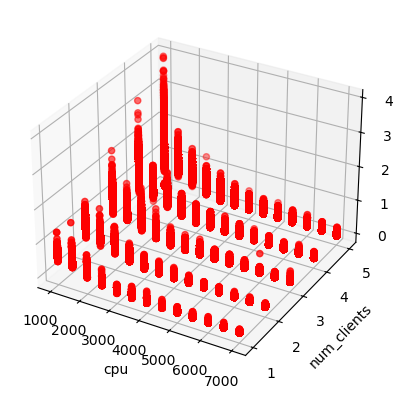

In [5]:
# visualize the data as a 3D plot
# x-axis: cpu
# y-axis: num_clients
# z-axis: model_time

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cpu_limit_list_read, num_clients_list_read, model_time_list_read, c='r', marker='o')
ax.set_xlabel('cpu')
ax.set_ylabel('num_clients')
ax.set_zlabel('model_time')
plt.show()

In [6]:
# covert read lists to np arrays
cpu_limit_list = np.array(cpu_limit_list_read)
num_clients_list = np.array(num_clients_list_read)
gpu_instance_list = np.array(gpu_instance_list_read)
gpu_memory_list = np.array(gpu_memory_list_read)
memory_limit_list = np.array(memory_limit_list_read)
image_size_list = np.array(image_size_list_read)
model_time_list = np.array(model_time_list_read)
print(len(cpu_limit_list), len(num_clients_list), len(gpu_instance_list), len(gpu_memory_list), len(memory_limit_list), len(image_size_list), len(model_time_list))
print("cpu limit list sample:", cpu_limit_list[:5])
print("num clients list sample:", num_clients_list[:5])
print("gpu instance list sample:", gpu_instance_list[:5])
print("gpu memory list sample:", gpu_memory_list[:5])
print("memory limit list sample:", memory_limit_list[:5])
print("image size list sample:", image_size_list[:5])
print("model time list sample:", model_time_list[:5])

369600 369600 369600 369600 369600 369600 369600
cpu limit list sample: [6500. 6500. 6500. 6500. 6500.]
num clients list sample: [2. 2. 2. 2. 2.]
gpu instance list sample: [0. 0. 0. 0. 0.]
gpu memory list sample: [0. 0. 0. 0. 0.]
memory limit list sample: [8. 8. 8. 8. 8.]
image size list sample: [688.13085938 688.13085938 688.13085938 688.13085938 688.13085938]
model time list sample: [0.04605126 0.03080106 0.02782106 0.05753851 0.02686   ]


In [7]:
# function to normalize the data to [0, 1]
def normalize_data(data_list):
    min_data = min(data_list)
    max_data = max(data_list)
    # if min_data == max_data, then return all zeros
    if min_data == max_data:
        return np.zeros_like(data_list), min_data, max_data
    else:
        normalized_data_list = (data_list - min_data) / (max_data - min_data)
        return normalized_data_list, min_data, max_data

369600 369600 369600 369600 369600 369600 369600
cpu limit list sample [0.91666667 0.91666667 0.91666667 0.91666667 0.91666667]
num clients list sample [0.25 0.25 0.25 0.25 0.25]
gpu instance list sample [0. 0. 0. 0. 0.]
gpu memory list sample [0. 0. 0. 0. 0.]
memory limit list sample [0. 0. 0. 0. 0.]
image size list sample [0.39960448 0.39960448 0.39960448 0.39960448 0.39960448]
model time list sample [0.00942693 0.00554112 0.00478181 0.01235392 0.00453693]


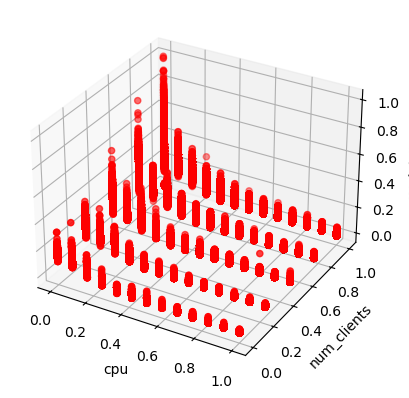

In [8]:
# normalize the data to [0,1]
cpu_limit_list_normalized, cpu_limit_min, cpu_limit_max = normalize_data(cpu_limit_list)
num_clients_list_normalized, num_clients_min, num_clients_max = normalize_data(num_clients_list)
gpu_instance_list_normalized, gpu_instance_min, gpu_instance_max = normalize_data(gpu_instance_list)
gpu_memory_list_normalized, gpu_memory_min, gpu_memory_max = normalize_data(gpu_memory_list)
memory_limit_list_normalized, memory_limit_min, memory_limit_max = normalize_data(memory_limit_list)
image_size_list_normalized, image_size_min, image_size_max = normalize_data(image_size_list)
model_time_list_normalized, model_time_min, model_time_max = normalize_data(model_time_list)

print(len(cpu_limit_list_normalized), len(num_clients_list_normalized), len(gpu_instance_list_normalized), len(gpu_memory_list_normalized), len(memory_limit_list_normalized), len(image_size_list_normalized), len(model_time_list_normalized))
print("cpu limit list sample", cpu_limit_list_normalized[:5])
print("num clients list sample", num_clients_list_normalized[:5])
print("gpu instance list sample", gpu_instance_list_normalized[:5])
print("gpu memory list sample", gpu_memory_list_normalized[:5])
print("memory limit list sample", memory_limit_list_normalized[:5])
print("image size list sample", image_size_list_normalized[:5])
print("model time list sample", model_time_list_normalized[:5])

# visualize the data as a 3D plot
# x-axis: cpu
# y-axis: num_clients
# z-axis: model_time
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cpu_limit_list_normalized, num_clients_list_normalized, model_time_list_normalized, c='r', marker='o')
ax.set_xlabel('cpu')
ax.set_ylabel('num_clients')
ax.set_zlabel('model_time')
plt.show()

In [9]:
# concatenate the lists except model_time_list_normalized as xpts
# one row in xpts is one data point
#    the order of columns in xpts is: cpu_limit, num_clients, gpu_instance, gpu_memory, memory_limit, image_size
xpts = np.column_stack((
    cpu_limit_list_normalized, 
    num_clients_list_normalized, 
    gpu_instance_list_normalized, 
    gpu_memory_list_normalized, 
    # memory_limit_list_normalized, 
    # image_size_list_normalized
    ))

print(xpts.shape)
# let model_time_list_normalized be ypts
ypts = model_time_list_normalized.reshape(-1,1)
print(ypts.shape)

assert xpts.shape[0] == ypts.shape[0], "number of data points not equal"

(369600, 4)
(369600, 1)


In [10]:
# sample data points every k data points
sample_rate = 20
xpts = xpts[::sample_rate]
ypts = ypts[::sample_rate]
print(xpts.shape)
print(ypts.shape)

(18480, 4)
(18480, 1)


In [11]:
# further divide the data into train, validation and test with ratio 8:1:1 by sampling evenly from the data
xpts_train = []
ypts_train = []
xpts_validation = []
ypts_validation = []
xpts_test = []
ypts_test = []

for idx in range(len(xpts)):
    if idx % 10 == 0:
        xpts_validation.append(xpts[idx])
        ypts_validation.append(ypts[idx])
    elif idx % 10 == 1:
        xpts_test.append(xpts[idx])
        ypts_test.append(ypts[idx])
    else:
        xpts_train.append(xpts[idx])
        ypts_train.append(ypts[idx])

In [12]:
# create dataloaders for train, validation and test
# convert the lists to np arrays
xpts_train = np.array(xpts_train)
ypts_train = np.array(ypts_train)
xpts_validation = np.array(xpts_validation)
ypts_validation = np.array(ypts_validation)
xpts_test = np.array(xpts_test)
ypts_test = np.array(ypts_test)

# convert the np arrays to tensors
xpts_train = torch.from_numpy(xpts_train).float()
ypts_train = torch.from_numpy(ypts_train).float()
xpts_validation = torch.from_numpy(xpts_validation).float()
ypts_validation = torch.from_numpy(ypts_validation).float()
xpts_test = torch.from_numpy(xpts_test).float()
ypts_test = torch.from_numpy(ypts_test).float()

# create TensorDatasets
train_dataset = TensorDataset(xpts_train, ypts_train)
validation_dataset = TensorDataset(xpts_validation, ypts_validation)
test_dataset = TensorDataset(xpts_test, ypts_test)

# create dataloaders
BATCH_SIZE = 16 # tweak the batch size for how many data points are fed to the trainer in one minibatch
NUM_WORKERS = 4
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# wrap the dataloaders in a dictionary
dataloaders = {
    "Train": train_dataloader,
    "Validation": validation_dataloader,
    "Test": test_dataloader,
}


## Train a Probabilistic Neural Network (PNN) model on the training data

To learn the conditional distribution Y|X, we will use a neural network model that outputs the mean and standard deviation of a Gaussian distribution (often called a Probabilistic Neural Net (PNN)). This model has been shown to have good performance, especially when ensembled ([Chua et al. 2018](https://arxiv.org/abs/1805.12114); [Lakshminarayanan et al. 2017](https://arxiv.org/abs/1612.01474)). However, the performance may suffer here since the true noise distribution is uniform instead of Gaussian. We will skip many of the details of the model and training since Uncertainty Toolbox is focused around model evaluation rather than model learning.

In [16]:
"""Make the PNN model."""
pnn = PNN(
    input_dim=4, # 4 features, cpu_limit, num_clients, gpu_instance, gpu_memory,
    output_dim=1, # 1 output, model_time
    encoder_hidden_sizes=[64, 128], # tweak these numbers for different pnn widths
    encoder_output_dim=64, # tweak this for the encoder output dimension
    mean_hidden_sizes=[],
    logvar_hidden_sizes=[],
)

In [13]:
torch.cuda.is_available()

True

In [14]:
# Train the model with a pytorch-lightning trainer for 10 epochs.
trainer = pl.Trainer(max_epochs=10, check_val_every_n_epoch=2, accelerator="gpu", devices="auto") # tweak the max_epochs to set epochs of training
trainer.fit(pnn, dataloaders['Train'], dataloaders['Validation'])
# Get the test output.
test_results = trainer.test(pnn, dataloaders['Test'])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/zli85/miniconda3/envs/uncertainty/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


NameError: name 'pnn' is not defined

In [19]:
# save the model
torch.save(pnn, 'pnn_model.pt')
# save the state_dict
torch.save(pnn.state_dict(), 'pnn_model_state_dict.pt')

## Visualize Model Uncertainties

In [15]:
# load the model
pnn = torch.load('pnn_model.pt')

In [16]:
import matplotlib
from typing import Union, Tuple, List, Any, NoReturn

In [17]:
def filter_subset(input_list: List[List[Any]], n_subset: int) -> List[List[Any]]:
    """Keep only n_subset random indices from all lists given in input_list.

    Args:
        input_list: list of lists.
        n_subset: Number of points to plot after filtering.

    Returns:
        List of all input lists with sizes reduced to n_subset.
    """
    assert type(n_subset) is int
    n_total = len(input_list[0])
    idx = np.random.choice(range(n_total), n_subset, replace=False)
    idx = np.sort(idx)
    output_list = []
    for inp in input_list:
        outp = inp[idx]
        output_list.append(outp)
    return output_list

In [78]:

def plot_xy(
    y_pred: np.ndarray,
    y_std: np.ndarray,
    y_true: np.ndarray,
    x: np.ndarray,
    title_text: str = "Confidence Band",
    font_size: int = 25,
    n_subset: Union[int, None] = None,
    ylims: Union[Tuple[float, float], None] = None,
    xlims: Union[Tuple[float, float], None] = None,
    num_stds_confidence_bound: int = 2,
    leg_loc: Union[int, str] = 3,
    ax: Union[matplotlib.axes.Axes, None] = None,
) -> matplotlib.axes.Axes:
    """Plot one-dimensional inputs with associated predicted values, predictive
    uncertainties, and true values.

    Args:
        y_pred: 1D array of the predicted means for the held out dataset.
        y_std: 1D array of the predicted standard deviations for the held out dataset.
        y_true: 1D array of the true labels in the held out dataset.
        x: 1D array of input values for the held out dataset.
        n_subset: Number of points to plot after filtering.
        ylims: a tuple of y axis plotting bounds, given as (lower, upper).
        xlims: a tuple of x axis plotting bounds, given as (lower, upper).
        num_stds_confidence_bound: width of confidence band, in terms of number of
            standard deviations.
        leg_loc: location of legend as a str or legend code int.
        ax: matplotlib.axes.Axes object.

    Returns:
        matplotlib.axes.Axes object with plot added.
    """
    # Create ax if it doesn't exist
    if ax is None:
        fig, ax = plt.subplots(figsize=(15,12))

    # Order points in order of increasing x
    order = np.argsort(x)
    y_pred, y_std, y_true, x = (
        y_pred[order],
        y_std[order],
        y_true[order],
        x[order],
    )

    # Optionally select a subset
    if n_subset is not None:
        [y_pred, y_std, y_true, x] = filter_subset([y_pred, y_std, y_true, x], n_subset)

    intervals = num_stds_confidence_bound * y_std

    # compute coverage for points in y_true[np.where(x == x_val)] falls in the interval y_pred - intervals and y_pred + intervals
    coverage = {} # x_val: coverage
    num_data_points = {} # x_val: number of data points
    
    # get average y_true for every x
    y_true_avg = []
    x_unique = np.unique(x)
    for x_val in x_unique:
        y_true_avg.append(np.mean(y_true[np.where(x == x_val)]))
    y_true_avg = np.array(y_true_avg)


    for i in range(len(x)):
        if x[i] not in coverage:
            coverage[x[i]] = 0
        if x[i] not in num_data_points:
            num_data_points[x[i]] = 0
        for j in range(len(y_true[i])):
            num_data_points[x[i]] += 1
            if y_true[i][j] >= y_pred[i] - intervals[i] and y_true[i][j] <= y_pred[i] + intervals[i]:
                coverage[x[i]] += 1
    for x_val in coverage:
        coverage[x_val] /= num_data_points[x_val]

    print("coverage:", coverage)
    print("average coverage:", np.mean(list(coverage.values())))
    print("number of data points:", num_data_points)

    h1 = ax.plot(x, y_true, ".", mec="#ff7f0e", mfc="None")
    h2 = ax.plot(x_unique, y_true_avg, "-", c="#ff0000", linewidth=2)
    h3 = ax.plot(x, y_pred, "-", c="#1f77b4", linewidth=2)
    h4 = ax.fill_between(
        x,
        y_pred - intervals,
        y_pred + intervals,
        color="lightsteelblue",
        alpha=0.4,
    )
    ax.legend(
        [h1[0], h2[0], h3[0], h4],
        ["Observations", "Averages", "Predictions", "$95\%$ Interval"],
        loc=leg_loc,
        fontsize=font_size
    )

    # Format plot
    ax.xaxis.set_tick_params(labelsize=font_size)
    ax.yaxis.set_tick_params(labelsize=font_size)
    if ylims is not None:
        ax.set_ylim(ylims)

    if xlims is not None:
        ax.set_xlim(xlims)

    # add text of coverage for every x_val right above the xticks
    for x_val in coverage:
        ax.text(x_val, ax.get_ylim()[0], "{:.0f}%".format(coverage[x_val]*100), fontsize=font_size, horizontalalignment='center', rotation=30)
    

    # x_tick_labels = ["{:.1f}".format(x_unique[i]/1000) + "\n" + "{:.0f}%".format(coverage[x_unique[i]]*100) for i in range(len(x_unique))]
    x_tick_labels = ["{:.1f}".format(x_unique[i]/1000) for i in range(len(x_unique))]

    ax.set_xticks(x_unique, x_tick_labels, minor=False, rotation=0)

    ax.set_xlabel(r"cpu limit ($\times 1000m$)" + "\nwith confidence band coverage on top", fontsize = font_size)
    ax.set_ylabel("model inference time ($s$)", fontsize = font_size)
    # ax.set_title(title_text, fontsize = font_size)
    ax.set_aspect(1.0 / ax.get_data_ratio(), adjustable="box")

    return ax

In [20]:
def draw_95_ci(xpts_test, ypts_test, pnn, title_text="Confidence Band"):
    te_x, te_y = np.array(xpts_test), np.array(ypts_test)
    pred_mean, pred_std = pnn.get_mean_and_standard_deviation(te_x)
    pred_mean = pred_mean.flatten()
    pred_std = pred_std.flatten()
    # # compute the coverage of 95% interval
    # covered_count = 0
    # total_count = 0
    # intervals95 = 2 * pred_std 
    # for idx in range(0, len(te_x)):
    #     for te_y_pts in te_y:
    #         total_count += 1
    #         if te_y_pts >= pred_mean[idx] - intervals95[idx] and te_y_pts <= pred_mean[idx] + intervals95[idx]:
    #             covered_count += 1
    # print("coverage ", covered_count / total_count)

    # Plot confidence bands on test data
    te_x_dim1 = te_x[:, 0]
    # denormalize the data
    te_x_dim1 = te_x_dim1 * (cpu_limit_max - cpu_limit_min) + cpu_limit_min
    te_y = te_y * (model_time_max - model_time_min) + model_time_min
    pred_mean = pred_mean * (model_time_max - model_time_min) + model_time_min
    pred_std = pred_std * (model_time_max - model_time_min) + model_time_min
    plot_xy(pred_mean, pred_std, te_y, te_x_dim1, title_text=title_text, leg_loc="upper right", font_size=25)
    # plt.gcf().set_size_inches(4, 4)
    plt.tight_layout()
    plt.savefig(title_text + ".png", dpi=300)
    plt.show()

In [21]:
# we split the test array according to different num_clients, gpu_instance, gpu_memory, memory_limit, image_size
print(len(data_points_lists))
print(data_points_lists.keys())
# get different cpu_limits, num_clients, gpu_instance, gpu_memory, memory_limit
cpu_limit_val_list = np.unique(cpu_limit_list)
print("unique cpu_limit", cpu_limit_val_list)
num_clients_val_list = np.unique(num_clients_list)
print("unique num_clients", num_clients_val_list)
gpu_instance_val_list = np.unique(gpu_instance_list)
print("unique gpu_instance", gpu_instance_val_list)
gpu_memory_val_list = np.unique(gpu_memory_list)
print("unique gpu_memory", gpu_memory_val_list)
memory_limit_val_list = np.unique(memory_limit_list)
print("unique memory_limit", memory_limit_val_list)

7
dict_keys(['cpu_limit', 'num_clients', 'gpu_instance', 'gpu_memory', 'memory_limit', 'image_size', 'model_time'])
unique cpu_limit [1000. 1500. 2000. 2500. 3000. 3500. 4000. 4500. 5000. 5500. 6000. 6500.
 7000.]
unique num_clients [1. 2. 3. 4. 5.]
unique gpu_instance [0. 1. 2. 3.]
unique gpu_memory [ 0.  5. 10. 20.]
unique memory_limit [8.]


In [22]:
# get unique cpu_limit, num_clients, gpu_instance, gpu_memory
cpu_limit_unique_val_list = np.unique(cpu_limit_list)
num_clients_unique_val_list = np.unique(num_clients_list)
gpu_instance_unique_val_list = np.unique(gpu_instance_list)
gpu_memory_unique_val_list = np.unique(gpu_memory_list)

In [23]:
# convert tensors to np arrays
# xpts_test = xpts_test.numpy()
# ypts_test = ypts_test.numpy()
xpts_test = np.array(xpts_train)
ypts_test = np.array(ypts_train)

test x shape (14784, 4)
test y shape (14784, 1)
unique x[:, 0] [0.         0.08333334 0.16666667 0.25       0.33333334 0.41666666
 0.5        0.5833333  0.6666667  0.75       0.8333333  0.9166667
 1.        ]
unique x[:, 1] [0.   0.25 0.5  0.75 1.  ]
unique x[:, 2] [0.         0.33333334 0.6666667  1.        ]
unique x[:, 3] [0.   0.25 0.5  1.  ]
number of datapoints: 936 in num_clients_val 1.0 gpu_instance_val 0.0 gpu_memory_val 0.0
x_test shape (14784, 4)
coverage: {1000.0: 1.0, 1500.0: 0.9583333333333334, 2000.0: 0.9861111111111112, 2500.0: 0.9722222222222222, 3000.0: 1.0, 3500.0: 0.9861111111111112, 4000.0: 1.0, 4500.0: 1.0, 5000.0: 1.0, 5500.0: 1.0, 6000.0: 1.0, 6500.0: 1.0, 7000.0: 1.0}
average coverage: 0.9925213675213675
number of data points: {1000.0: 72, 1500.0: 72, 2000.0: 72, 2500.0: 72, 3000.0: 72, 3500.0: 72, 4000.0: 72, 4500.0: 72, 5000.0: 72, 5500.0: 72, 6000.0: 72, 6500.0: 72, 7000.0: 72}


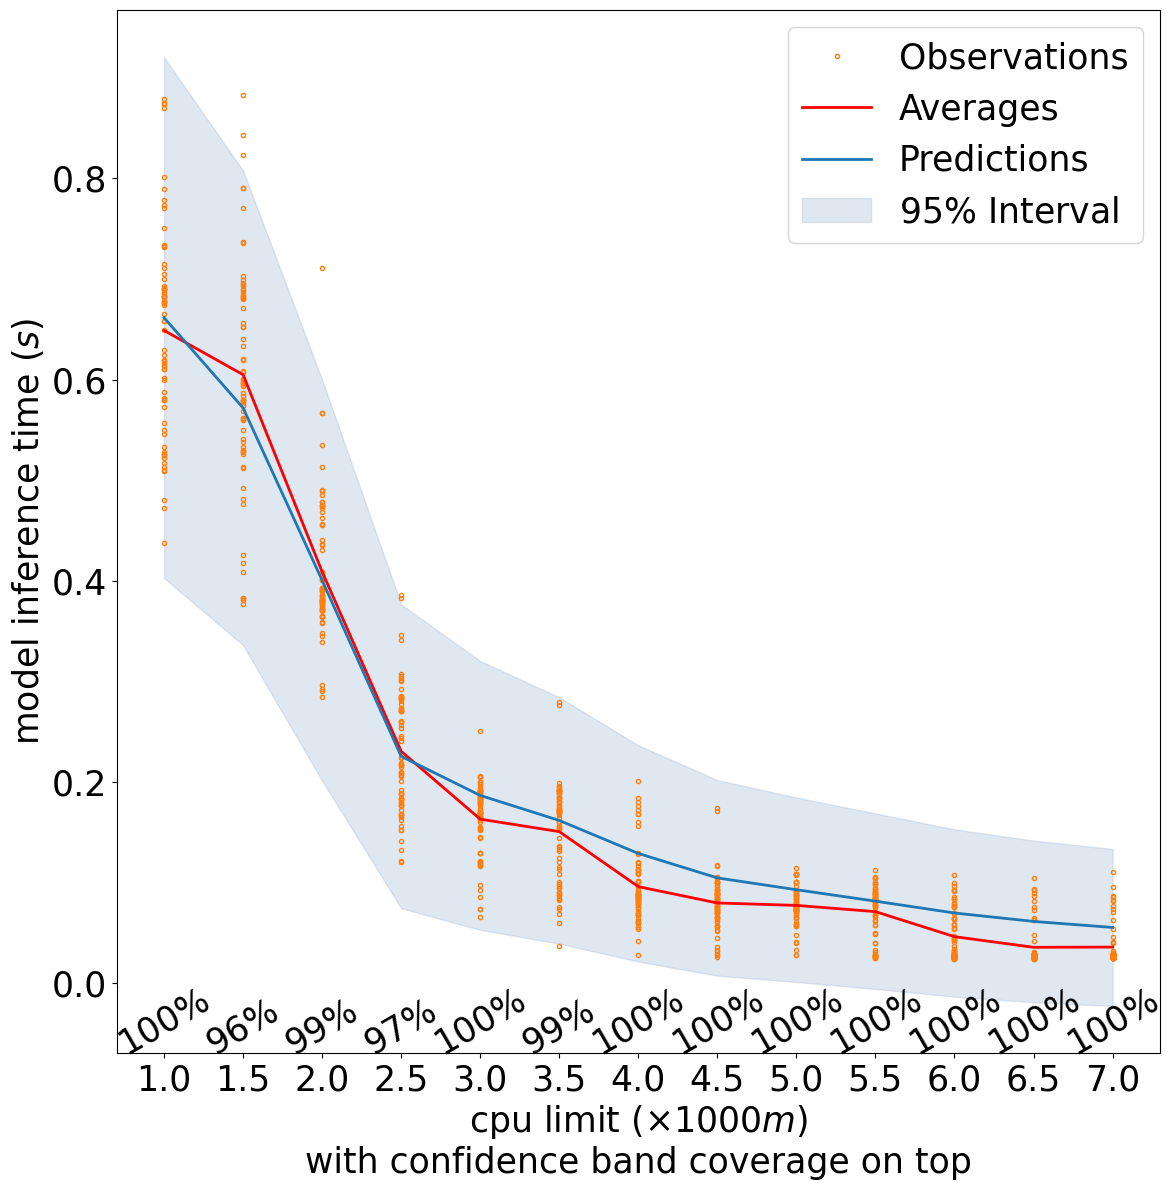

number of datapoints: 1872 in num_clients_val 2.0 gpu_instance_val 0.0 gpu_memory_val 0.0
x_test shape (14784, 4)
coverage: {1000.0: 0.9652777777777778, 1500.0: 0.9861111111111112, 2000.0: 0.9513888888888888, 2500.0: 0.9652777777777778, 3000.0: 1.0, 3500.0: 0.9861111111111112, 4000.0: 1.0, 4500.0: 1.0, 5000.0: 1.0, 5500.0: 1.0, 6000.0: 1.0, 6500.0: 1.0, 7000.0: 1.0}
average coverage: 0.9887820512820512
number of data points: {1000.0: 144, 1500.0: 144, 2000.0: 144, 2500.0: 144, 3000.0: 144, 3500.0: 144, 4000.0: 144, 4500.0: 144, 5000.0: 144, 5500.0: 144, 6000.0: 144, 6500.0: 144, 7000.0: 144}


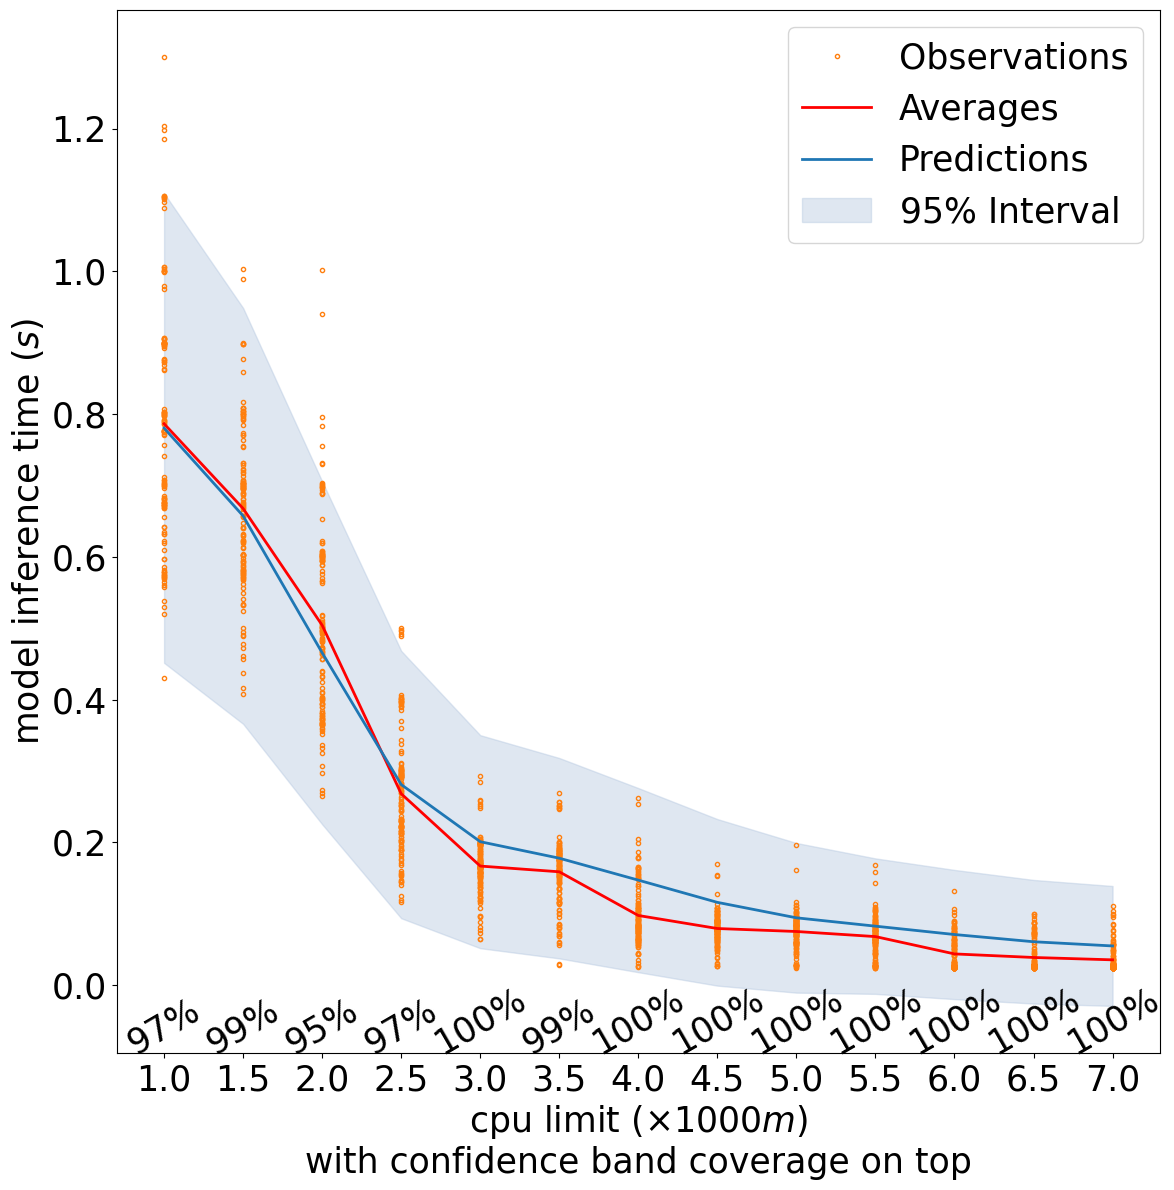

number of datapoints: 2832 in num_clients_val 3.0 gpu_instance_val 0.0 gpu_memory_val 0.0
x_test shape (14784, 4)
coverage: {1000.0: 0.9916666666666667, 1500.0: 0.9907407407407407, 2000.0: 0.9537037037037037, 2500.0: 0.9953703703703703, 3000.0: 1.0, 3500.0: 0.9907407407407407, 4000.0: 0.9953703703703703, 4500.0: 0.9583333333333334, 5000.0: 0.9953703703703703, 5500.0: 1.0, 6000.0: 1.0, 6500.0: 0.9907407407407407, 7000.0: 1.0}
average coverage: 0.9893874643874644
number of data points: {1000.0: 240, 1500.0: 216, 2000.0: 216, 2500.0: 216, 3000.0: 216, 3500.0: 216, 4000.0: 216, 4500.0: 216, 5000.0: 216, 5500.0: 216, 6000.0: 216, 6500.0: 216, 7000.0: 216}


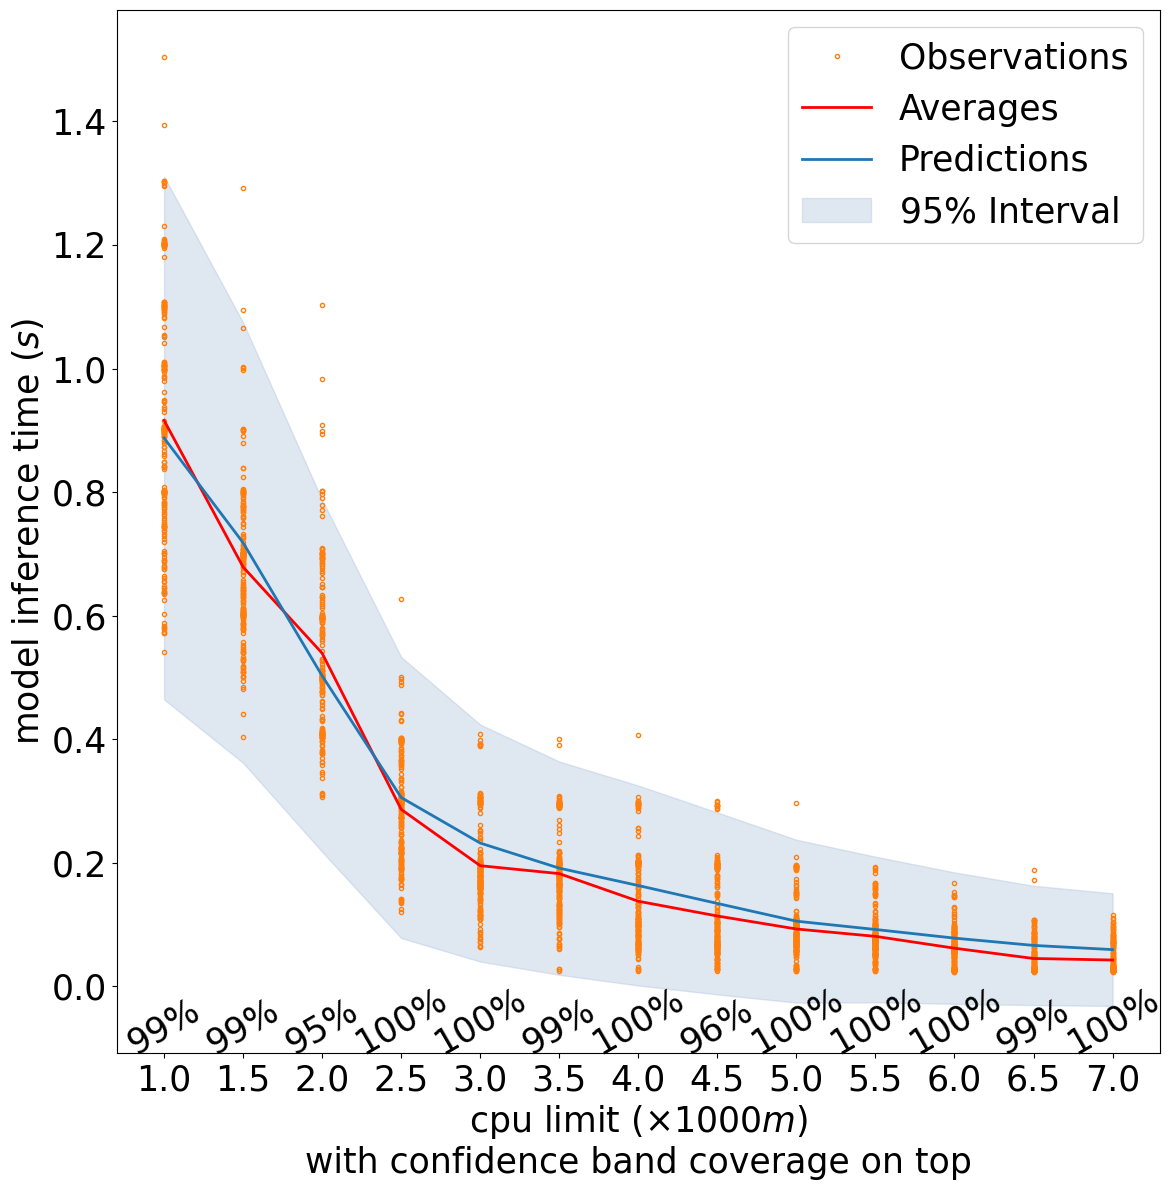

number of datapoints: 3744 in num_clients_val 4.0 gpu_instance_val 0.0 gpu_memory_val 0.0
x_test shape (14784, 4)
coverage: {1000.0: 0.9791666666666666, 1500.0: 1.0, 2000.0: 0.9930555555555556, 2500.0: 0.9930555555555556, 3000.0: 1.0, 3500.0: 0.9930555555555556, 4000.0: 1.0, 4500.0: 1.0, 5000.0: 0.9965277777777778, 5500.0: 1.0, 6000.0: 1.0, 6500.0: 0.9965277777777778, 7000.0: 0.9895833333333334}
average coverage: 0.9954594017094018
number of data points: {1000.0: 288, 1500.0: 288, 2000.0: 288, 2500.0: 288, 3000.0: 288, 3500.0: 288, 4000.0: 288, 4500.0: 288, 5000.0: 288, 5500.0: 288, 6000.0: 288, 6500.0: 288, 7000.0: 288}


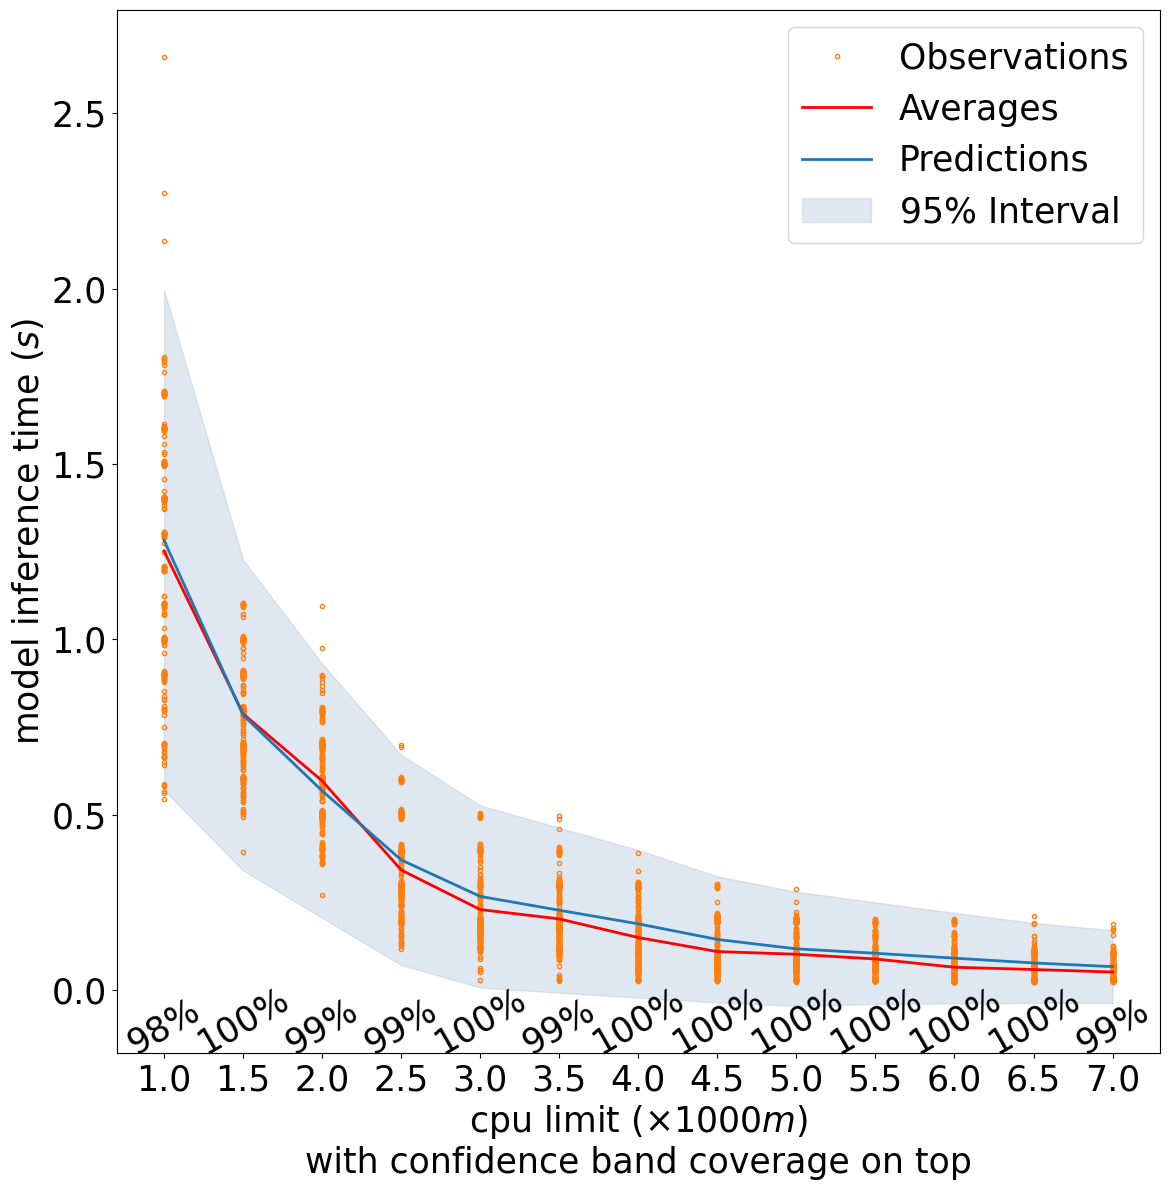

number of datapoints: 4680 in num_clients_val 5.0 gpu_instance_val 0.0 gpu_memory_val 0.0
x_test shape (14784, 4)
coverage: {1000.0: 0.9861111111111112, 1500.0: 1.0, 2000.0: 1.0, 2500.0: 0.9972222222222222, 3000.0: 0.9833333333333333, 3500.0: 0.9861111111111112, 4000.0: 0.9972222222222222, 4500.0: 1.0, 5000.0: 0.9972222222222222, 5500.0: 0.9694444444444444, 6000.0: 0.9888888888888889, 6500.0: 0.9916666666666667, 7000.0: 0.9916666666666667}
average coverage: 0.9914529914529916
number of data points: {1000.0: 360, 1500.0: 360, 2000.0: 360, 2500.0: 360, 3000.0: 360, 3500.0: 360, 4000.0: 360, 4500.0: 360, 5000.0: 360, 5500.0: 360, 6000.0: 360, 6500.0: 360, 7000.0: 360}


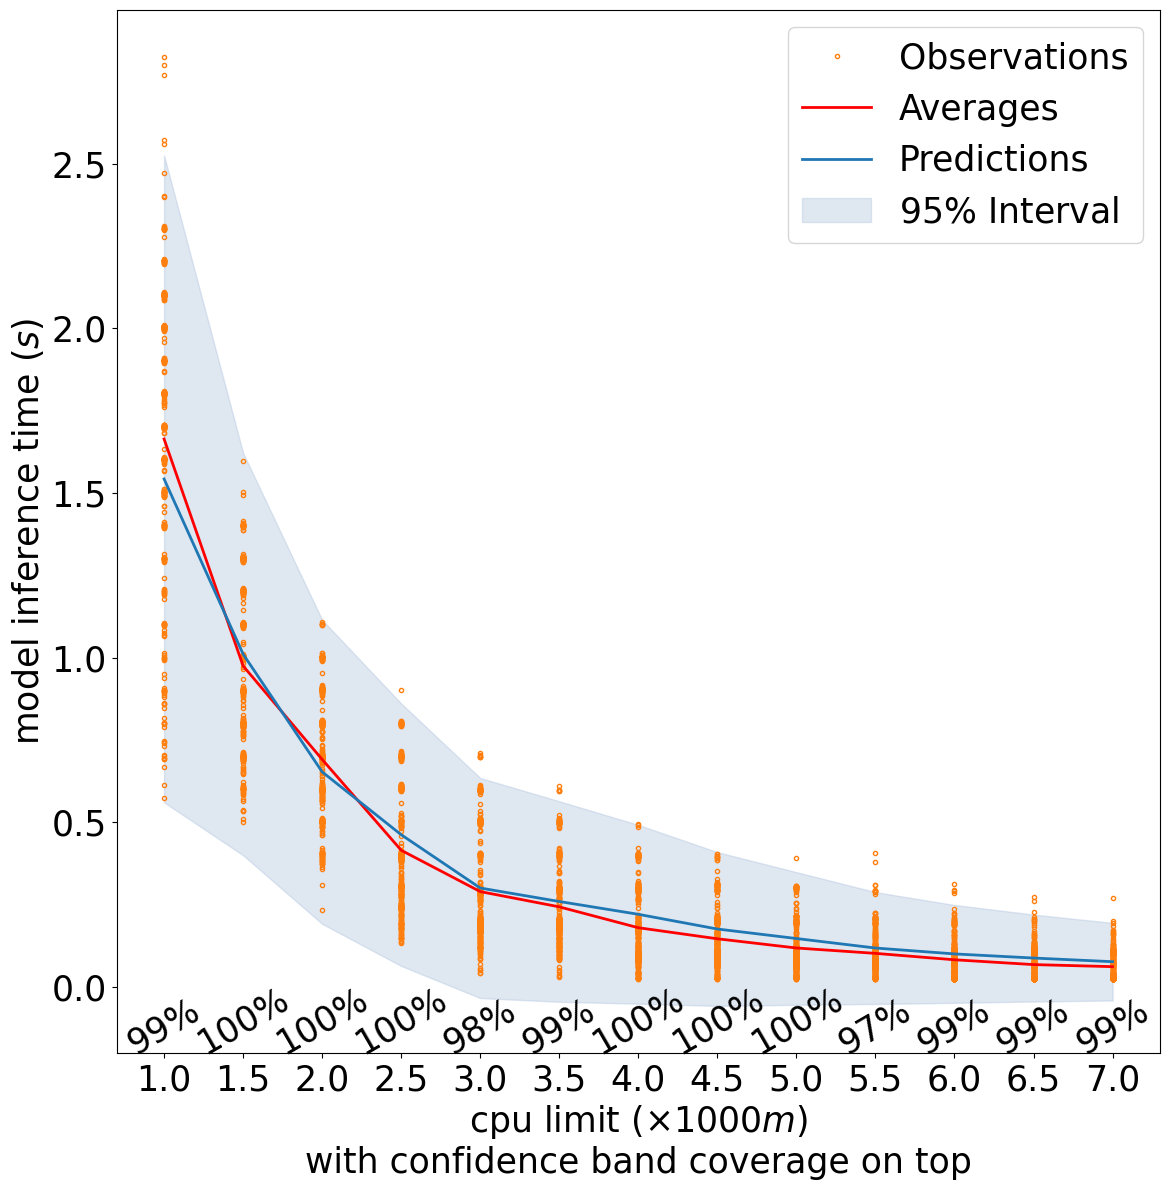

number of datapoints: 240 in num_clients_val 5.0 gpu_instance_val 3.0 gpu_memory_val 20.0
x_test shape (14784, 4)
coverage: {1000.0: 1.0, 7000.0: 1.0}
average coverage: 1.0
number of data points: {1000.0: 120, 7000.0: 120}


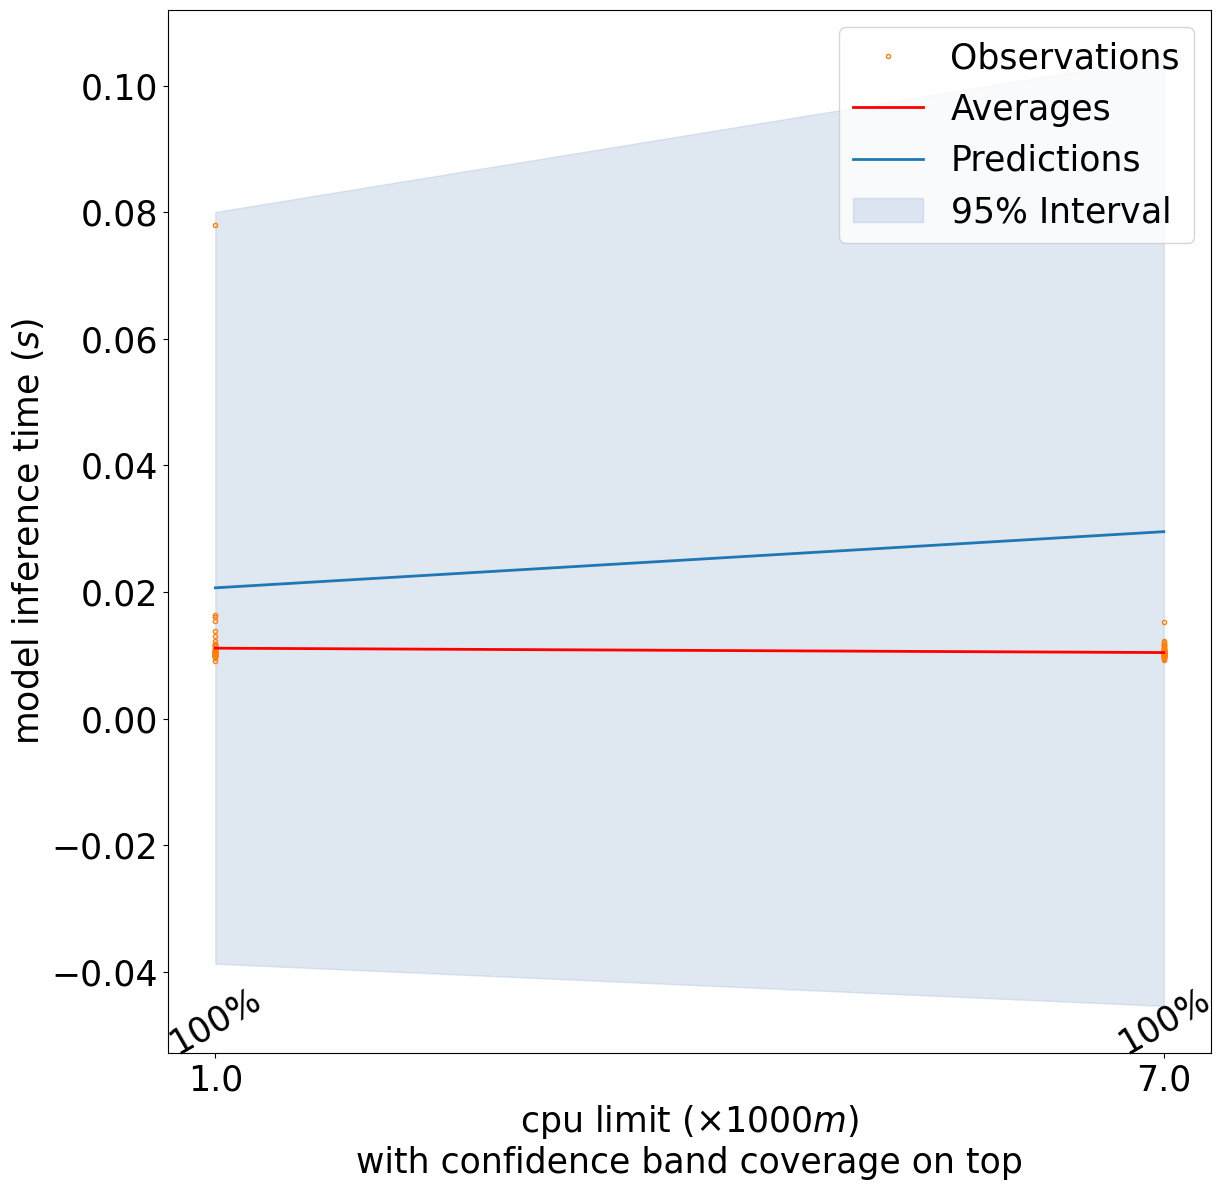

In [79]:
print("test x shape", xpts_test.shape)
print("test y shape", ypts_test.shape)

# get unique values in x[:, 0], x[:, 1], x[:, 2], x[:, 3]
x_0_unique_val_list = np.unique(xpts_test[:, 0])
x_1_unique_val_list = np.unique(xpts_test[:, 1])
x_2_unique_val_list = np.unique(xpts_test[:, 2])
x_3_unique_val_list = np.unique(xpts_test[:, 3])
print("unique x[:, 0]", x_0_unique_val_list)
print("unique x[:, 1]", x_1_unique_val_list)
print("unique x[:, 2]", x_2_unique_val_list)
print("unique x[:, 3]", x_3_unique_val_list)

for num_clients_val in num_clients_unique_val_list:
    for gpu_instance_val in gpu_instance_unique_val_list:
        for gpu_memory_val in gpu_memory_unique_val_list:
            # filter the test data by num_clients_val, gpu_instance_val, gpu_memory_val
            xpts_test_filtered = []
            ypts_test_filtered = []
            num_clients_val_normalized = (num_clients_val - num_clients_min) / (num_clients_max - num_clients_min)
            gpu_instance_val_normalized = (gpu_instance_val - gpu_instance_min) / (gpu_instance_max - gpu_instance_min)
            gpu_memory_val_normalized = (gpu_memory_val - gpu_memory_min) / (gpu_memory_max - gpu_memory_min)
            for idx in range(len(xpts_test)):
                if xpts_test[idx][1] == num_clients_val_normalized and xpts_test[idx][2] == gpu_instance_val_normalized and xpts_test[idx][3] == gpu_memory_val_normalized:
                    xpts_test_filtered.append(xpts_test[idx])
                    ypts_test_filtered.append(ypts_test[idx])
            xpts_test_filtered = np.array(xpts_test_filtered)
            ypts_test_filtered = np.array(ypts_test_filtered)
            if len(xpts_test_filtered) == 0:
                # print("no data points for num_clients_val", num_clients_val, "gpu_instance_val", gpu_instance_val, "gpu_memory_val", gpu_memory_val)
                continue
            else:
                print("number of datapoints:", len(xpts_test_filtered), "in num_clients_val", num_clients_val, "gpu_instance_val", gpu_instance_val, "gpu_memory_val", gpu_memory_val)
                print("x_test shape", xpts_test.shape)
            # xpts_test_filtered = np.array(xpts_test_filtered)
            # ypts_test_filtered = np.array(ypts_test_filtered)
            draw_95_ci(xpts_test_filtered, ypts_test_filtered, pnn, title_text="Confidence Band for num_clients=" + str(num_clients_val) + " gpu_instance=" + str(gpu_instance_val) + " gpu_memory=" + str(gpu_memory_val))